# Курсовая работа

Импорт библиотек

In [188]:
import re, math, codecs, os

In [189]:
from pprint import pprint
import numpy as np

In [190]:
import gensim
from gensim.models import word2vec
from gensim.models import Word2Vec

In [191]:
import warnings # убираем предупреждения для публикации кода

warnings.filterwarnings('ignore')

Подключение модели

In [192]:
m_wv = "to.bin"

In [193]:
model = gensim.models.KeyedVectors.load_word2vec_format(m_wv, binary=True, unicode_errors='ignore')

In [194]:
len(model.wv.vocab)

1689654

## Визуализация ближайших соседей (t-SNE)

In [195]:
keys = ['тоесть', 'кошка']
embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = [model[word]]
    words = [word]
    for similar_word, _ in model.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [196]:
embedding_clusters = np.array(embedding_clusters)
embedding_clusters.shape

(2, 11, 300)

In [197]:
from sklearn.manifold import TSNE

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)


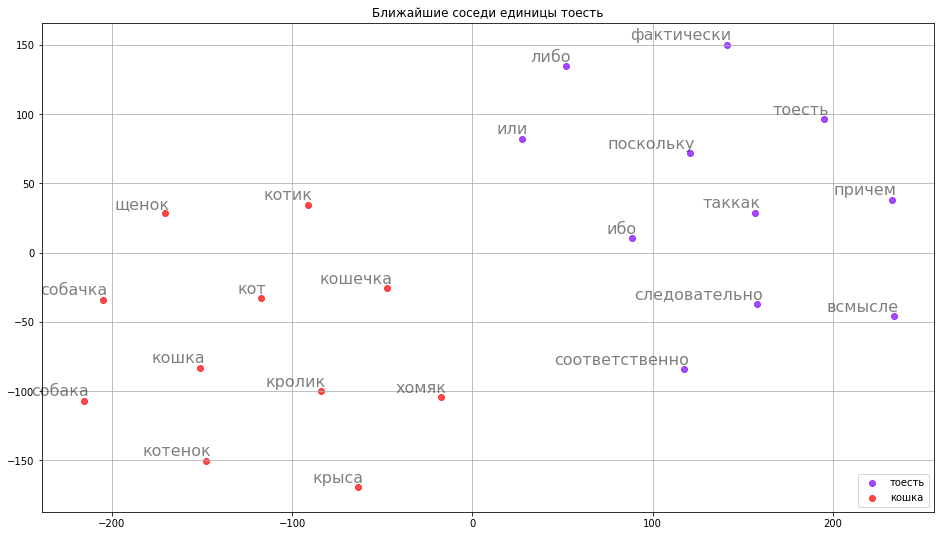

In [198]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
% matplotlib inline


def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=16)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Ближайшие соседи единицы тоесть', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')  # Сохраняем изображение

## Подсчет двух типов близости контекста

In [199]:
# Косинусная близость
def cos(vA, vB):
    cos = np.dot(vA, vB) / (np.sqrt(np.dot(vA,vA)) * np.sqrt(np.dot(vB,vB)))
    return cos

In [200]:
info = []
words = []
final = []
# Считываем предложения с разметкой
with open('sentences.txt') as fh:
    sentences = fh.readlines()
for sentence in sentences:
    sentence.strip()
    sentence = sentence.split()
    count = 0
    for word in sentence:
        info.append(word)
        if len(info) == 3:
            words.append(info)
            info = []
    final.append(words)
    words = []

## Подсчет близости слов справа и слева

Найдем самую большую косинусную близость между парами слов справа и слева от *то есть*

In [201]:
similar_words = []  # Набор значений близостей пар слов
for sentence in final:
    left_list = []
    best = -100
    ind = 0
    for word in sentence:
        if word[0] == 'тоесть':
            ind = 1 # Индикатор было ли то есть
            continue
        if not ind:
            pass
            try:
                left_list.append(model.wv[word[1]]) # Собираем список векторов левого контекста
            except Exception as e:
                print(e)
        elif ind:
            try:
                right = model.wv[word[1]]
                for vector in left_list:
                    best = max(best, cos(vector, right)) # Максимальное значение косинусной близости пар слов
            except Exception as e:
                continue
#                print(e)
    similar_words.append(best)

"word 'летесть' not in vocabulary"
"word 'эсэмэску' not in vocabulary"
"word 'эсэмэску' not in vocabulary"
"word 'биоресурсы' not in vocabulary"
"word 'амфимиксис' not in vocabulary"
"word 'двухипостасный' not in vocabulary"
"word 'лазебной' not in vocabulary"
"word 'усмановна' not in vocabulary"
"word 'шурупский' not in vocabulary"
"word 'трлн' not in vocabulary"
"word 'тераэлектрон' not in vocabulary"
"word 'брейвик' not in vocabulary"
"word 'сабетта' not in vocabulary"
"word 'барбей' not in vocabulary"
"word 'натрехмерный' not in vocabulary"
"word 'доносилва' not in vocabulary"
"word 'трлн' not in vocabulary"
"word 'обывателиус' not in vocabulary"
"word 'пушкарная' not in vocabulary"
"word 'губпросвет' not in vocabulary"
"word 'вучик' not in vocabulary"
"word 'троллят' not in vocabulary"
"word 'трлн' not in vocabulary"
"word 'менгхин' not in vocabulary"
"word 'полож' not in vocabulary"
"word 'пильганова' not in vocabulary"
"word 'фейстоп' not in vocabulary"
"word 'экзотоксикант' not

In [202]:
# Запишем данные в файл
with open('word_sim.txt', 'w') as fw:
    for i in similar_words:
        fw.write(str(i))
        fw.write('\n')

## Подсчет близости контекстов справа и слева

Найдем близость среднего вектора контекста справа и слева от *то есть*

In [203]:
sentence_counts = []  # Значения косинусной близости средних векторов контекстов
for sentence in final:
    left_sum = 0
    right_sum = 0
    count_l = 0
    count_r = 0
    ind = 0
    for word in sentence:
        if word[0] == 'тоесть':
            ind = 1  # Индикатор было ли то есть
            continue
        if not ind:
            pass
            try:
                count_l += 1
                left_sum += model.wv[word[1]]  # Складываем слова слева
            except Exception as e:
                print(e)
        elif ind:
            try:
                count_r += 1
                right_sum += model.wv[word[1]]  # Складываем слова справа
            except Exception as e:
                continue
#                print(e)
    if count_l != 0 and count_r != 0:
        count = (left_sum / count_l, right_sum / count_l)
        sentence_counts.append(count)
    else:
        count = (left_sum, right_sum)
        sentence_counts.append(count)        

"word 'летесть' not in vocabulary"
"word 'эсэмэску' not in vocabulary"
"word 'эсэмэску' not in vocabulary"
"word 'биоресурсы' not in vocabulary"
"word 'амфимиксис' not in vocabulary"
"word 'двухипостасный' not in vocabulary"
"word 'лазебной' not in vocabulary"
"word 'усмановна' not in vocabulary"
"word 'шурупский' not in vocabulary"
"word 'трлн' not in vocabulary"
"word 'тераэлектрон' not in vocabulary"
"word 'брейвик' not in vocabulary"
"word 'сабетта' not in vocabulary"
"word 'барбей' not in vocabulary"
"word 'натрехмерный' not in vocabulary"
"word 'доносилва' not in vocabulary"
"word 'трлн' not in vocabulary"
"word 'обывателиус' not in vocabulary"
"word 'пушкарная' not in vocabulary"
"word 'губпросвет' not in vocabulary"
"word 'вучик' not in vocabulary"
"word 'троллят' not in vocabulary"
"word 'трлн' not in vocabulary"
"word 'менгхин' not in vocabulary"
"word 'полож' not in vocabulary"
"word 'пильганова' not in vocabulary"
"word 'фейстоп' not in vocabulary"
"word 'экзотоксикант' not

In [204]:
# Укажем номер по порядку
count = 1
similar_contexts = []
for i in sentence_counts:
    similar_contexts.append([count, cos(i[0], i[1])])
    count += 1

In [205]:
# Есть случаи, когда один из контекстов не определен
for i in similar_contexts:
    if isinstance(i[1], np.ndarray):
        i[1] = 0

In [206]:
print(len(similar_contexts))
sorted_sim = sorted(similar_contexts, key=lambda x: x[1], reverse=True)

1000


In [207]:
# Запишем все в файл, чтобы работать с ним на локальном компьютере
with open('part_sim.txt', 'w') as fw:
    for i in sorted_sim:
        a, b = i
        fw.write(str(a) + ' ' + str(b) + '\n')

## Средние векторы по каждому типу значения

In [208]:
# Вектор - сумма векторов слов
context = [sum(i) for i in sentence_counts]

In [209]:
# Скачиваем разметку
with open('Разметка.txt') as fh:
    tags = list(map(lambda l: l.strip(), fh.readlines()))
print(len(tags))

1000


In [210]:
from collections import Counter

In [211]:
unique = Counter(tags)
unique

Counter({'дискурс': 12,
         'дополнение': 83,
         'интерпретация': 234,
         'коррекция': 40,
         'модальность': 2,
         'обобщение': 51,
         'обр определение': 4,
         'определение': 81,
         'переспрос': 7,
         'переспрос инт': 49,
         'переспрос как': 7,
         'переформулирование': 109,
         'пример': 8,
         'следствие': 258,
         'спецификация': 55})

In [212]:
# Находим средние вектора
average = {}
for x, y in zip(tags, context):
    if x not in average.keys():
        average[x] = 0
    average[x] += y
for name, count in unique.items():
    average[name] /= count    

In [213]:
from pymystem3 import Mystem
ms = Mystem()

In [214]:
# Это функция для парсинга предложения
def vectorise(item):
    item = re.sub('[Тт]о есть', 'тоесть', item)
    punctuation = (list(""",;:”$%^&*№()_—=+!...?|[]{}\"/<>`~±§«»°1234567890.""")
               + ['- ', ' -', ' - ', '― ', ' ―', ' ― ', " '", "' "])
    item = item.lower()
    for char in punctuation:
        item = item.replace(char, ' ')
    item = item.strip()
    lemmas = ms.lemmatize(item)
    vector = 0
    for word in lemmas:
        if word != 'тоедать' and ' ' not in word:
            try:
                vector+=model.wv[word]
            except Exception as e:
                pass
    return vector

In [215]:
# Это функция для подсчета близости к типам значения
def find_type(sentence):
    vector = vectorise(sentence) # Превращаем предложение в вектор
    types = []
    for key in average.keys():
        types.append((key, cos(average[key], vector))) # Считаем близость нашего вектора и вектора-прототипа
    types = sorted(types, reverse=True, key=lambda x: float(x[1])) # Сортируем
    return types

## Оценка предсказательной силы

In [216]:
with open('examples.txt') as fh:
    lines = fh.readlines()

In [217]:
pprint(lines[:5])

['%дискурс\n',
 'А вот о возможностях фото и видео контента стоит рассказать немного '
 'подробнее. </s> <s> То есть в том понимании, как видит все это наша студия и '
 'ее сотрудники. !\n',
 'В этот день Якопо Бельбо глядел в глаза Истине … И это, то есть мгновение, '
 'когда он затормозил пространство и время !\n',
 'Раз предлагал даже зайти в ближайший салон связи, купить ей телефон и только '
 'оставить свой - то есть перезвонила бы если захотела .. !\n',
 '―\xa0Нам\xa0нужно,\xa0чтоб\xa0нас\xa0всех\xa0черти\xa0разорвали… То есть, '
 'черт возьми, я говорю, чтоб, тысяча чертей, тысяча залпов вам в задницу… '
 'черт!  [Митьки. Папуас из Гондураса (1987)] [омонимия не снята] !\n']


In [218]:
meanings = {}
for line in lines:
    if line.startswith('%'): # В файле идет название значения, а потом примеры таких употреблений
        line = line.strip()
        line = line.strip('%')
        key = line
        meanings[key] = []
    else:
        line = line.strip()
        line = line.replace(u'\xa0', ' ')
        line = re.sub('\[.+?\]', '', line)
        line = re.sub('\<.+?\>', '', line)
        meanings[key].append(line)

In [219]:
for key in meanings.keys():
    print(key, len(meanings[key]))

следствие 10
обобщение 10
переспрос 10
пример 10
переспрос инт 10
коррекция 10
дискурс 10
определение 10
спецификация 10
переформулирование 10
дополнение 10
переспрос как 10
интерпретация 10


In [220]:
median_prediction = []
for key, sentences in meanings.items():
    position = []
    for sentence in sentences:
        types = find_type(sentence) # Ищем ранжирование типов по каждому предложению
        for i in range(1, len(types)+1):
            if types[i-1][0] == key: # Запоминаем позицию нужного
                position.append(i)
    median_prediction.append((key, np.median(position))) # Собираем медианы предсказаний

Получается, что лучше всего программа ловит дискурсивные значения *то есть*, а не союзные

In [221]:
median_prediction = sorted(median_prediction, key=lambda x: x[1])
median_prediction

[('коррекция', 1.0),
 ('переспрос', 2.0),
 ('определение', 2.5),
 ('следствие', 3.0),
 ('переспрос инт', 3.5),
 ('дискурс', 4.0),
 ('переформулирование', 4.0),
 ('дополнение', 4.0),
 ('интерпретация', 6.0),
 ('пример', 7.0),
 ('спецификация', 7.0),
 ('обобщение', 8.0),
 ('переспрос как', 10.5)]

## Предсказания для отдельных предложений

In [222]:
sentence = 'И здесь соблюдалась полная демократия, то есть картину отбирал по своему вкусу очередной дежурный '

Это был пример следствия

In [223]:
find_type(sentence)

[('дополнение', 0.49646387),
 ('переформулирование', 0.49464464),
 ('следствие', 0.47175238),
 ('переспрос инт', 0.44966534),
 ('спецификация', 0.43783745),
 ('интерпретация', 0.428271),
 ('пример', 0.42404312),
 ('обобщение', 0.41845536),
 ('коррекция', 0.38692376),
 ('определение', 0.3796479),
 ('обр определение', 0.3568918),
 ('дискурс', 0.30305752),
 ('переспрос', 0.2543023),
 ('модальность', 0.24200524),
 ('переспрос как', 0.16896102)]

In [224]:
sentence = 'Очень, очень, очень желает с тобой познакомиться! — Да с какой же стати очень-то? — То есть не то чтобы... видишь, в последнее время, вот как ты заболел, мне часто и много приходилось об тебе поминать... Ну, он слушал... и как узнал, что ты по юридическому и кончить курса не можешь, по обстоятельствам, то сказал: «Как жаль!» Я и заключил... то есть всё это вместе, не одно ведь это; вчера Заметов...'

А вот тут да, дискурсивное + коррекция

In [225]:
find_type(sentence)

[('коррекция', 0.8345981),
 ('переспрос', 0.66444075),
 ('модальность', 0.649335),
 ('дискурс', 0.60710835),
 ('переспрос инт', 0.5093532),
 ('интерпретация', 0.4326337),
 ('следствие', 0.40162003),
 ('дополнение', 0.38091367),
 ('переспрос как', 0.36725906),
 ('переформулирование', 0.32998458),
 ('пример', 0.31459954),
 ('спецификация', 0.3097917),
 ('обр определение', 0.23680076),
 ('обобщение', 0.23121443),
 ('определение', 0.171176)]

In [226]:
sentence = 'Не дальше, как сегодня, то есть в субботу, опять со статьей произошло что-то'

Дополнение

In [227]:
find_type(sentence)

[('коррекция', 0.5870863),
 ('модальность', 0.3988665),
 ('переспрос', 0.36593),
 ('дискурс', 0.29356867),
 ('переспрос инт', 0.28157365),
 ('интерпретация', 0.23318017),
 ('дополнение', 0.2053265),
 ('переспрос как', 0.19805361),
 ('следствие', 0.19701575),
 ('переформулирование', 0.16128781),
 ('пример', 0.15274444),
 ('спецификация', 0.13818322),
 ('обобщение', 0.08339409),
 ('обр определение', 0.048011523),
 ('определение', 0.039526027)]

In [228]:
sentence = 'Он вникал в глубину этого сравнения и разбирал, что такое другие и что он сам, в какой степени возможна и справедлива эта параллель и как тяжела обида, нанесенная ему Захаром; наконец, сознательно ли оскорбил его Захар, то есть убежден ли он был, что Илья Ильич всё равно, что «другой», или так это сорвалось у него с языка, без участия головы'

Интерпретация

In [229]:
find_type(sentence)

[('коррекция', 0.6849089),
 ('переспрос инт', 0.5766381),
 ('модальность', 0.54515266),
 ('переспрос', 0.5402034),
 ('дополнение', 0.53942215),
 ('следствие', 0.5211004),
 ('интерпретация', 0.5183997),
 ('переформулирование', 0.4998029),
 ('дискурс', 0.49539855),
 ('спецификация', 0.4515638),
 ('пример', 0.44867957),
 ('обобщение', 0.40390095),
 ('обр определение', 0.37540218),
 ('определение', 0.3723401),
 ('переспрос как', 0.2135355)]

In [230]:
sentence = 'Недоверчив, скептик, циник... надувать любит, то есть не надувать, а дурачить...'

Коррекция

In [231]:
find_type(sentence)

[('коррекция', 0.61111975),
 ('переспрос', 0.52047914),
 ('переспрос как', 0.4836254),
 ('дискурс', 0.47677955),
 ('модальность', 0.42416152),
 ('переспрос инт', 0.3421536),
 ('интерпретация', 0.29362494),
 ('следствие', 0.2685734),
 ('дополнение', 0.25317886),
 ('спецификация', 0.21385588),
 ('переформулирование', 0.20698303),
 ('пример', 0.18612926),
 ('обобщение', 0.1367163),
 ('обр определение', 0.12662798),
 ('определение', 0.07190362)]

In [232]:
sentence = '― Я вечный двигатель изобрел.  ― То есть как? ― спросил Аркадий Максимович Фетисов. '

Переспрос как

In [233]:
find_type(sentence)

[('коррекция', 0.44792897),
 ('переспрос как', 0.38327762),
 ('переспрос', 0.3653465),
 ('дискурс', 0.32223785),
 ('модальность', 0.31283477),
 ('переспрос инт', 0.20357259),
 ('дополнение', 0.16124123),
 ('интерпретация', 0.14511849),
 ('спецификация', 0.1148869),
 ('следствие', 0.10626988),
 ('переформулирование', 0.07470271),
 ('пример', 0.061679058),
 ('обобщение', 0.030053873),
 ('обр определение', 0.023682129),
 ('определение', -0.005514154)]

In [234]:
sentence = '― У меня было плохое настроение.   ― То есть?   ― Мне показалось, что все уже было… '

Переспрос

In [235]:
find_type(sentence)

[('коррекция', 0.8154006),
 ('модальность', 0.6904732),
 ('переспрос', 0.6542083),
 ('дискурс', 0.5524111),
 ('переспрос инт', 0.45652768),
 ('интерпретация', 0.40393516),
 ('переспрос как', 0.3833468),
 ('следствие', 0.35151908),
 ('дополнение', 0.29680344),
 ('пример', 0.259354),
 ('спецификация', 0.2400244),
 ('переформулирование', 0.23602137),
 ('обр определение', 0.20430605),
 ('обобщение', 0.14350344),
 ('определение', 0.09449407)]

# Классификатор

Попробуем построить более сложный классификатор из встроенных в sklearn

In [236]:
import pandas as pd

In [237]:
# Создадим словарь объектов и ответов
dic = {}
dic['context'] = [i[0]+i[1] for i in sentence_counts]
dic['tags'] = tags
dic['type'] = [tag in ['коррекция', 'модальность', 'переспрос', 'дискурс', 'переспрос инт', 'переспрос как']
               for tag in tags]  # Дискурсивное значение то есть или нет

In [238]:
# Сделаем датафрейм
df = pd.DataFrame(dic)

In [239]:
X = df['context'].to_numpy() # Множество объектов
y = df['tags'].to_numpy().reshape((-1, 1)) # Множество ответов

Создадим отложенную выборку для оценки качества модели

In [240]:
from sklearn.model_selection import train_test_split

In [241]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Начнем работать с моделями

In [242]:
from sklearn.metrics import classification_report

**KNN**

In [243]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [244]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [245]:
classifier = KNeighborsClassifier(n_neighbors=5, metric='cosine')
classifier.fit(list(X_train), y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='cosine',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [246]:
y_pred = classifier.predict(list(X_test))
accuracy_score(y_test, y_pred)

0.208

In [247]:
from sklearn.metrics.pairwise import cosine_similarity

In [248]:
grid_params = {
    'n_neighbors' : [3, 5, 7],
    'weights' : ['uniform', 'distance'],
    'metric' : ['euclidean', 'manhattan', 'cosine']
}

In [249]:
gs = GridSearchCV(
    KNeighborsClassifier(),
    grid_params,
    verbose=1,
    cv=3,
    n_jobs=-1
    )

In [250]:
gs_model = gs.fit(list(X_train), y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    4.1s finished


In [251]:
y_pred = gs_model.predict(list(X_test))

In [252]:
print(classification_report(y_test, y_pred))

                    precision    recall  f1-score   support

           дискурс       0.00      0.00      0.00         1
        дополнение       0.00      0.00      0.00        14
     интерпретация       0.44      0.28      0.34        68
         коррекция       0.33      0.30      0.32        10
       модальность       0.00      0.00      0.00         1
         обобщение       0.12      0.38      0.18        13
   обр определение       0.00      0.00      0.00         1
       определение       0.43      0.18      0.25        17
         переспрос       0.00      0.00      0.00         0
     переспрос инт       0.00      0.00      0.00        13
     переспрос как       0.00      0.00      0.00         3
переформулирование       0.25      0.08      0.12        26
            пример       0.00      0.00      0.00         2
         следствие       0.28      0.48      0.36        64
      спецификация       0.17      0.06      0.09        17

          accuracy                    

**Random Forest**

In [253]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

In [254]:
rnd_clf = RandomForestClassifier(random_state=42)

In [255]:
rnd_clf.fit(list(X_train), y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [256]:
y_pred = rnd_clf.predict(list(X_test))

In [257]:
accuracy_score(y_test, y_pred)

0.264

In [258]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [259]:
rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

rf_model = rf_random.fit(list(X_train), y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.4min finished


In [260]:
rf_model.best_params_

{'bootstrap': True,
 'max_depth': 100,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 400}

In [261]:
y_pred = rf_model.predict(list(X_test))

In [262]:
print(classification_report(y_test, y_pred))

                    precision    recall  f1-score   support

           дискурс       0.00      0.00      0.00         1
        дополнение       0.00      0.00      0.00        14
     интерпретация       0.39      0.56      0.46        68
         коррекция       0.50      0.20      0.29        10
       модальность       0.00      0.00      0.00         1
         обобщение       0.00      0.00      0.00        13
   обр определение       0.00      0.00      0.00         1
       определение       0.60      0.18      0.27        17
     переспрос инт       0.00      0.00      0.00        13
     переспрос как       0.00      0.00      0.00         3
переформулирование       0.00      0.00      0.00        26
            пример       0.00      0.00      0.00         2
         следствие       0.34      0.73      0.46        64
      спецификация       0.00      0.00      0.00        17

          accuracy                           0.36       250
         macro avg       0.13      0.1

**Logistic Regression**

In [263]:
from sklearn.linear_model import LogisticRegression

In [264]:
log_clf = LogisticRegression(random_state=42)

In [265]:
log_clf.fit(list(X_train), y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [266]:
y_pred = log_clf.predict(list(X_test))
accuracy_score(y_test, y_pred)

0.292

In [267]:
grid = {"C" : np.logspace(-3, 3, 7), "penalty" : ["l1", "l2"]}
log = LogisticRegression()
log_cv = GridSearchCV(log, grid, cv=10)
log_cv.fit(list(X_train), y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [268]:
y_pred = log_cv.predict(list(X_test))

In [269]:
print(classification_report(y_test, y_pred))

                    precision    recall  f1-score   support

           дискурс       0.00      0.00      0.00         1
        дополнение       0.00      0.00      0.00        14
     интерпретация       0.40      0.28      0.33        68
         коррекция       0.33      0.20      0.25        10
       модальность       0.00      0.00      0.00         1
         обобщение       0.00      0.00      0.00        13
   обр определение       0.00      0.00      0.00         1
       определение       0.33      0.06      0.10        17
     переспрос инт       0.00      0.00      0.00        13
     переспрос как       0.00      0.00      0.00         3
переформулирование       0.17      0.04      0.06        26
            пример       0.00      0.00      0.00         2
         следствие       0.27      0.78      0.40        64
      спецификация       0.00      0.00      0.00        17

          accuracy                           0.29       250
         macro avg       0.11      0.1

**SVM**

In [270]:
from sklearn import svm

In [271]:
svm_clf = svm.LinearSVC()
svm_clf.fit(list(X_train), y_train)
y_pred = svm_clf.predict(list(X_test))
accuracy_score(y_test, y_pred)

0.252

In [272]:
param_grid = {'C': [0.1, 1, 10, 100, 1000]}  
  
grid = GridSearchCV(svm.LinearSVC(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(list(X_train), y_train)
y_pred = grid.predict(list(X_test))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.278, total=   0.1s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ............................... C=0.1, score=0.272, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.265, total=   0.1s
[CV] C=1 .............................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV] ................................. C=1, score=0.259, total=   0.3s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.252, total=   0.3s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.294, total=   0.3s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.196, total=   0.9s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.224, total=   0.8s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.229, total=   0.9s
[CV] C=100 ...........................................................
[CV] ............................... C=100, score=0.188, total=   1.5s
[CV] C=100 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   13.6s finished


In [273]:
print(classification_report(y_test, y_pred))

                    precision    recall  f1-score   support

           дискурс       0.00      0.00      0.00         1
        дополнение       0.00      0.00      0.00        14
     интерпретация       0.42      0.29      0.34        68
         коррекция       0.33      0.20      0.25        10
       модальность       0.00      0.00      0.00         1
         обобщение       0.00      0.00      0.00        13
   обр определение       0.00      0.00      0.00         1
       определение       0.33      0.12      0.17        17
     переспрос инт       0.00      0.00      0.00        13
     переспрос как       0.00      0.00      0.00         3
переформулирование       0.00      0.00      0.00        26
            пример       0.00      0.00      0.00         2
         следствие       0.27      0.77      0.40        64
      спецификация       0.00      0.00      0.00        17

          accuracy                           0.29       250
         macro avg       0.10      0.1

# Контрольная выборка

In [274]:
# Функция для обработки предложений контрольной выборки
def cont_sim(sentences):
    vectors = []
    final = []
    for sentence in sentences:
        item = re.sub('[Тт]о есть', 'тоесть', sentence)
        punctuation = (list(""",;:”$%^&*№()_—=+!...?|[]{}…\"/<>`~±§«»°1234567890.""")
                       + ['- ', ' -', ' - ', '― ', ' ―', ' ― ', " '", "' "])
        item = item.lower()
        for char in punctuation:
            item = item.replace(char, ' ')
        item = item.strip()
        lemmas = ms.lemmatize(item)
        item = [i for i in lemmas if ' ' not in i and '\n' not in i]
        final.append(item)
    count = 1
    for sentence in final:
        sent_vec = np.zeros((300,))
        for word in sentence:
            if word != 'тоедать':  # Mystem лемматизирует его как тоедать
                try:
                    sent_vec += model.wv[word]
                except Exception as e:
                    continue
        vectors.append([count, sent_vec])
        count += 1
    return vectors

In [275]:
X_control = []
y_control = []
for key in meanings.keys():
    vector = cont_sim(meanings[key])
    X_control.extend(i[1] for i in vector)
    y_control.extend([key for i in vector])

 ## Визуализация данных (t-SNE)

In [276]:
keys = meanings.keys()
embedding_clusters = []
word_clusters = []
dic = {}
for vec, key in zip(X_control, y_control):
    if key not in dic.keys():
        dic[key] = [] 
    dic[key].append(np.array(vec))
embedding_clusters = np.array([np.array(dic[i]) for i in dic.keys()])
word_clusters = [[i for j in dic[i]] for i in dic.keys()]

In [277]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

In [278]:
def tsne_plot_similar_words(title, labels, embedding_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, color in zip(labels, embedding_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, s=60, label=label)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=200, bbox_inches='tight')
    plt.show()

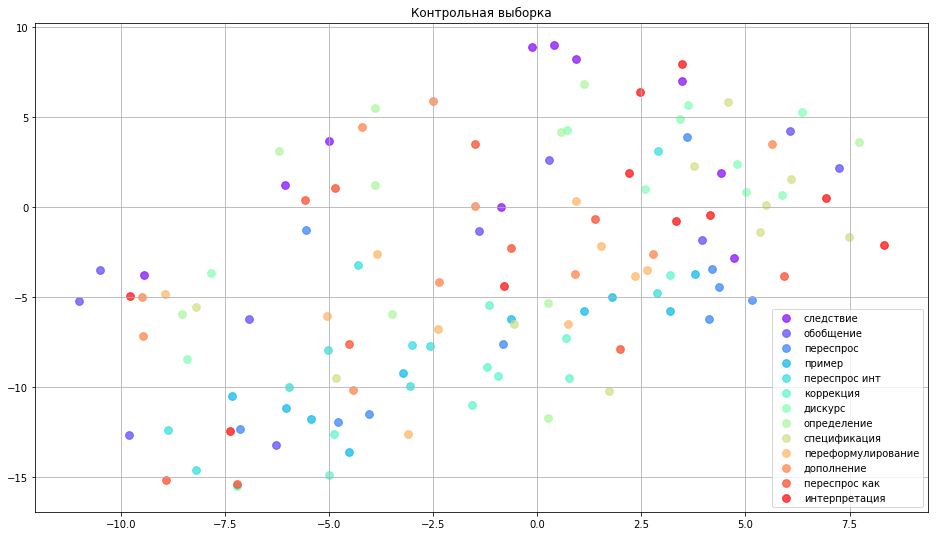

In [279]:
tsne_plot_similar_words('Контрольная выборка', keys, embeddings_en_2d, 0.7,
                        'control_set.png')

Видно, что данные достаточно сложные

## Работа моделей на контрольной выборке

In [280]:
# Метод опорных векторов
y_pred = grid.predict(X_control)
accuracy_score(y_control, y_pred)

0.14615384615384616

In [281]:
# Логистическая регрессия
y_pred = log_cv.predict(X_control)
accuracy_score(y_control, y_pred)

0.13076923076923078

In [282]:
# Случайный лес
y_pred = rf_model.predict(X_control)
accuracy_score(y_control, y_pred)

0.13846153846153847

In [283]:
# Метод ближайших соседей
y_pred = gs_model.predict(X_control)
accuracy_score(y_control, y_pred)

0.14615384615384616

# Обобщенная задача

Мы видим, что качество алгоритмов не очень хорошее, попробуем обобщить задачу. Проведем бинарную классификацию: дискурсивное значение или союзное

In [284]:
X = df['context'].to_numpy() # Множество объектов
y = df['type'].to_numpy().reshape((-1, 1)) # Множество ответов

Создадим отложенную выборку для оценки качества модели

In [285]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Начнем работать с моделями

**KNN**

In [286]:
classifier = KNeighborsClassifier()
classifier.fit(list(X_train), y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [287]:
y_pred = classifier.predict(list(X_test))
accuracy_score(y_test, y_pred)

0.884

In [288]:
grid_params = {
    'n_neighbors' : [3, 5, 7],
    'weights' : ['uniform', 'distance'],
    'metric' : ['euclidean', 'manhattan', 'cosine']
}

In [289]:
gs = GridSearchCV(
    KNeighborsClassifier(),
    grid_params,
    verbose=1,
    cv=3,
    n_jobs=-1
    )

In [290]:
gs_model = gs.fit(list(X_train), y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    4.0s finished


In [291]:
y_pred = gs_model.predict(list(X_test))

In [292]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.91      0.96      0.93       222
        True       0.44      0.25      0.32        28

    accuracy                           0.88       250
   macro avg       0.67      0.60      0.63       250
weighted avg       0.86      0.88      0.87       250



**Random Forest**

In [293]:
rnd_clf = RandomForestClassifier(random_state=42)

In [294]:
rnd_clf.fit(list(X_train), y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [295]:
y_pred = rnd_clf.predict(list(X_test))

In [296]:
accuracy_score(y_test, y_pred)

0.86

In [297]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [298]:
rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

rf_model = rf_random.fit(list(X_train), y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.7min finished


In [299]:
y_pred = rf_model.predict(list(X_test))

In [300]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.89      0.99      0.94       222
        True       0.40      0.07      0.12        28

    accuracy                           0.88       250
   macro avg       0.65      0.53      0.53       250
weighted avg       0.84      0.88      0.85       250



**Logistic Regression**

In [301]:
log_clf = LogisticRegression(random_state=42)

In [302]:
log_clf.fit(list(X_train), y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [303]:
y_pred = log_clf.predict(list(X_test))
accuracy_score(y_test, y_pred)

0.892

In [304]:
grid = {"C" : np.logspace(-3, 3, 7), "penalty" : ["l1", "l2"]}
log = LogisticRegression()
log_cv = GridSearchCV(log, grid, cv=10)
log_cv.fit(list(X_train), y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [305]:
y_pred = log_cv.predict(list(X_test))

In [306]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.90      0.99      0.94       222
        True       0.60      0.11      0.18        28

    accuracy                           0.89       250
   macro avg       0.75      0.55      0.56       250
weighted avg       0.86      0.89      0.86       250



**SVM**

In [307]:
svm_clf = svm.LinearSVC()
svm_clf.fit(list(X_train), y_train)
y_pred = svm_clf.predict(list(X_test))
accuracy_score(y_test, y_pred)

0.868

In [308]:
param_grid = {'C': [0.1, 1, 10, 100, 1000]}  
  
grid_cv = GridSearchCV(svm.LinearSVC(), param_grid, refit = True, verbose = 3) 
  
grid_cv.fit(list(X_train), y_train)
y_pred = grid_cv.predict(list(X_test))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.900, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.876, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.888, total=   0.0s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.888, total=   0.0s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.880, total=   0.0s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.896, total=   0.0s
[CV] C=10 ............................................................
[CV] ............

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.888, total=   0.1s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.896, total=   0.1s
[CV] C=100 ...........................................................
[CV] ............................... C=100, score=0.825, total=   0.2s
[CV] C=100 ...........................................................
[CV] ............................... C=100, score=0.848, total=   0.2s
[CV] C=100 ...........................................................
[CV] ............................... C=100, score=0.867, total=   0.2s
[CV] C=1000 ..........................................................
[CV] .............................. C=1000, score=0.821, total=   0.2s
[CV] C=1000 ..........................................................
[CV] .............................. C=1000, score=0.840, total=   0.2s
[CV] 

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.3s finished


In [309]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.89      0.99      0.94       222
        True       0.50      0.07      0.12        28

    accuracy                           0.89       250
   macro avg       0.70      0.53      0.53       250
weighted avg       0.85      0.89      0.85       250



# Работа моделей на контрольной выборке

In [310]:
X_cont_bin = []
y_cont_bin = []
for key in meanings.keys():
    vector = cont_sim(meanings[key])
    if key in ['коррекция', 'модальность', 'переспрос', 'дискурс', 'переспрос инт', 'переспрос как']:
        type_cont = True
    else:
        type_cont = False
    X_cont_bin.extend(i[1] for i in vector)
    y_cont_bin.extend([type_cont for i in vector])

In [311]:
# Метод опорных векторов
y_pred = grid_cv.predict(X_cont_bin)
accuracy_score(y_cont_bin, y_pred)

0.7692307692307693

In [312]:
# Логистическая регрессия
y_pred = log_cv.predict(X_cont_bin)
accuracy_score(y_cont_bin, y_pred)

0.8

In [313]:
# Случайный лес
y_pred = rf_model.predict(X_cont_bin)
accuracy_score(y_cont_bin, y_pred)

0.7

In [314]:
# Метод ближайших соседей
y_pred = gs_model.predict(X_cont_bin)
accuracy_score(y_cont_bin, y_pred)

0.6153846153846154

Лучше всего работает логистическая регрессия, обучим ее на всех данных

In [315]:
grid = {"C" : np.logspace(-3, 3, 7), "penalty" : ["l1", "l2"]}
log = LogisticRegression()
final_model = GridSearchCV(log, grid, cv=10)
final_model.fit(list(X), y)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [316]:
y_pred = final_model.predict(X_cont_bin)

In [317]:
print(classification_report(y_cont_bin, y_pred))

              precision    recall  f1-score   support

       False       0.87      0.76      0.81        80
        True       0.68      0.82      0.75        50

    accuracy                           0.78       130
   macro avg       0.78      0.79      0.78       130
weighted avg       0.80      0.78      0.79       130



Мы видим, что у итоговой модели достаточно хорошие метрики качества

## Визуализация данных

In [318]:
keys = meanings.keys()
embedding_clusters = []
word_clusters = []
dic = {}
for vec, key in zip(X_control, y_control):
    typ = 'False'
    if key in ['коррекция', 'переспрос', 'дискурс', 'переспрос инт', 'переспрос как']:
        typ = 'True'
    if typ not in dic.keys():
        dic[typ] = []
    if len(dic[typ]) < 50:  # У нас только 5 дискурсивных значений в тестовой выборке
        dic[typ].append([np.array(vec), key])
embedding_clusters = np.array([[k[0] for k in dic[i]] for i in dic.keys()])
word_clusters = [[k[1] for k in dic[i]] for i in dic.keys()]

In [319]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

In [320]:
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=10)
 #   loss = expit(X_cont_bin * final_model.best_estimator_.coef_ + final_model.best_estimator_.intercept_).ravel()
#    plt.plot(X_cont_bin, loss, color='red', linewidth=3)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

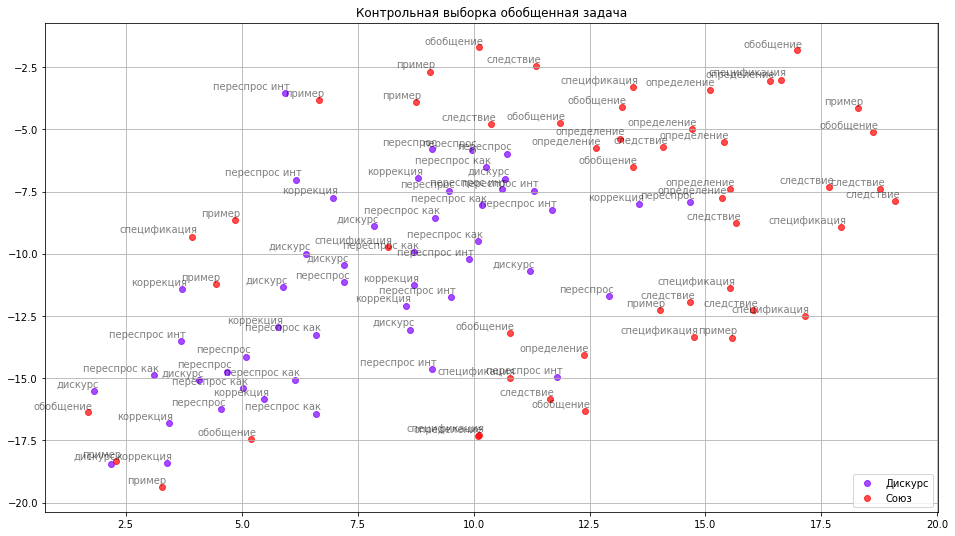

In [321]:
tsne_plot_similar_words('Контрольная выборка обобщенная задача', ['Дискурс', 'Союз'], embeddings_en_2d, word_clusters, 0.7,
                        'control_set_binary_1.png')

Каждая точка имеет тег – тип значения *то есть*

Видно, что данные достаточно хорошо разделимы